# Texture Analysis Notebook

This notebook provides an easy-to-use tool for performing texture analysis on medical images (CT or MRI).

- **CT images:**
  - Uses SimpleITK to read images and convert them to a TIFF-supported pixel type (casting to 32‑bit float if needed).
  - Computes texture features using the Gray-Level Co-occurrence Matrix (GLCM).

- **MRI images:**
  - Uses the `tifffile` package (which can handle 64‑bit TIFF images) to read the image.
  - Normalizes the image to a 0–255 scale, converts it to 8‑bit, and then computes texture features using the GLCM.

**Additional features:**
- Black frame images (images with a maximum pixel value of 0) are automatically skipped.
- The notebook automatically creates a converted subfolder and output CSV file based on the selected image directory.

**Instructions:**
1. Adjust the `image_directory` (the folder containing your images) and set the `modality` ("CT" or "MRI") in the main cell.
2. Run the notebook cells in order. Output will be at the **end!**

---

## Explanation of Texture Analysis Methods

The notebook computes several texture features based on the Gray-Level Co-occurrence Matrix (GLCM). Each metric provides information about the spatial distribution and relationship of pixel intensities within the image. Here is what each metric means and how it might help in identifying organs or differentiating imaging modalities:

- **Contrast:**
  - **What It Measures:**  
    Contrast quantifies the local variations in the image. High contrast indicates a high degree of local intensity differences.
  - **Clinical Insight:**  
    Organs or lesions with heterogeneous tissue (e.g., malignant tumors) tend to show higher contrast, while more uniform tissues (such as healthy liver or muscle) may exhibit lower contrast.

- **Correlation:**
  - **What It Measures:**  
    Correlation measures how correlated a pixel is to its neighbor over the entire image. It provides an idea of the linear dependency of gray levels in the image.
  - **Clinical Insight:**  
    A high correlation can indicate more uniform texture patterns, which may help in distinguishing organs with homogenous tissue structure from those with a more varied tissue composition.

- **Energy:**
  - **What It Measures:**  
    Energy (also called Angular Second Moment) is the sum of squared elements in the GLCM. It reflects the textural uniformity of the image.
  - **Clinical Insight:**  
    High energy values are often associated with regions that have very uniform texture (for instance, smooth tissues), while lower energy may indicate more complex textures.

- **Homogeneity:**
  - **What It Measures:**  
    Homogeneity measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal. It indicates the smoothness of the texture.
  - **Clinical Insight:**  
    Organs with smooth, uniform tissue (like certain muscles or healthy tissues) tend to have higher homogeneity, while tissues with abrupt changes (such as lesions or fibrotic tissue) exhibit lower homogeneity.

- **Basic Statistics (Mean, Standard Deviation, Median):**
  - **What They Measure:**  
    These statistics provide information about the intensity distribution within the image. The mean gives the average intensity, the standard deviation shows the spread of intensities, and the median offers a robust central value.
  - **Clinical Insight:**  
    In CT scans, these statistics may correlate with known quantitative values (like Hounsfield Units), helping to differentiate bone, soft tissue, and air. In MRI, where absolute intensity values can be less standardized, these measures still provide useful comparisons between different regions or between patients.

---

## Differences Between MRI and CT Data

- **CT Data:**
  - Typically quantifies tissue density in Hounsfield Units.
  - High-resolution CT images can provide detailed information about bone structures and calcifications.
  - Texture features derived from CT data may be more directly linked to physical density differences.

- **MRI Data:**
  - Offers superior contrast for soft tissue differentiation.
  - Intensities in MRI are relative and depend on the pulse sequence used.
  - Texture features from MRI can help in distinguishing subtle differences in soft tissues that may not be as visible on CT, even though the absolute intensity values differ.

By analyzing these texture metrics, clinicians and researchers can gain additional quantitative insights that may assist in identifying specific organs, characterizing tissue types, and even differentiating between benign and malignant lesions.

---

You can now proceed with the rest of the notebook cells that contain the import statements, function definitions, and the main execution code.


In [6]:
!pip install numpy pandas matplotlib SimpleITK scikit-image tifffile jupyter

## Import Packages

In [7]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

# For MRI reading (64-bit TIFFs)
try:
    import tifffile
except ImportError:
    tifffile = None

# Enable inline plotting in Jupyter
%matplotlib inline

## CT Processing Functions

In [8]:
def ensure_ct_image(input_path, output_path):
    try:
        image = sitk.ReadImage(input_path)
    except Exception as e:
        print(f"Error reading CT image {input_path} with SimpleITK: {e}")
        return None
    # Allowed pixel types for TIFF writing.
    allowed_types = [sitk.sitkUInt8, sitk.sitkInt8, sitk.sitkUInt16, sitk.sitkInt16, sitk.sitkFloat32]
    if image.GetPixelID() not in allowed_types:
        image = sitk.Cast(image, sitk.sitkFloat32)
        print(f"Casting CT image {input_path} to 32-bit float (sitkFloat32).")
    try:
        sitk.WriteImage(image, output_path)
        print(f"Saved CT converted image to {output_path}")
    except Exception as e:
        print(f"Error writing CT image to {output_path}: {e}")
        return None
    return output_path

def analyze_ct_texture(image_path):
    try:
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)
        # Skip completely black images.
        if np.max(image_array) == 0:
            print(f"Skipping CT image {image_path} because it is a black frame.")
            return None

        image_array = img_as_ubyte(image_array)
        distances = [5]
        angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
        glcm = graycomatrix(image_array, distances=distances, angles=angles,
                            symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        mean_val = np.mean(image_array)
        std_val = np.std(image_array)
        median_val = np.median(image_array)
        return {
            'contrast': contrast,
            'correlation': correlation,
            'energy': energy,
            'homogeneity': homogeneity,
            'mean': mean_val,
            'std': std_val,
            'median': median_val
        }
    except Exception as e:
        print(f"Error processing CT image {image_path}: {e}")
        return None

## MRI Processing Functions

In [9]:
def analyze_mri_texture(image_path):
    try:
        if tifffile is None:
            raise ImportError("tifffile is required for MRI processing. Install it with 'pip install tifffile'.")
        image_np = tifffile.imread(image_path)
        print(f"Read MRI image {image_path} with dtype {image_np.dtype}")

        # Skip completely black images.
        if np.max(image_np) == 0:
            print(f"Skipping MRI image {image_path} because it is a black frame.")
            return None

        # Min-max normalize to 0-255.
        img_min = np.min(image_np)
        img_max = np.max(image_np)
        if img_max - img_min != 0:
            norm_image = (image_np - img_min) / (img_max - img_min)
        else:
            norm_image = image_np - img_min
        image_uint8 = (norm_image * 255).astype(np.uint8)

        distances = [5]
        angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
        glcm = graycomatrix(image_uint8, distances=distances, angles=angles,
                            symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        mean_val = np.mean(image_uint8)
        std_val = np.std(image_uint8)
        median_val = np.median(image_uint8)
        return {
            'contrast': contrast,
            'correlation': correlation,
            'energy': energy,
            'homogeneity': homogeneity,
            'mean': mean_val,
            'std': std_val,
            'median': median_val
        }
    except Exception as e:
        print(f"Error processing MRI image {image_path}: {e}")
        return None

## Image Stack Analysis Function

In [10]:
def analyze_image_stack(image_directory, modality, output_csv, converted_dir=None):
    all_features = {}
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith('.tif')]

    def extract_number(filename):
        match = re.search(r'_(\d{4})\.tif$', filename)
        return int(match.group(1)) if match else 0

    image_files.sort(key=extract_number)

    if modality.upper() == "CT":
        if converted_dir is None:
            converted_dir = os.path.join(image_directory, "CT_converted")
        if not os.path.exists(converted_dir):
            os.makedirs(converted_dir)
        for image_file in image_files:
            original_path = os.path.join(image_directory, image_file)
            converted_path = os.path.join(converted_dir, image_file)
            ct_path = ensure_ct_image(original_path, converted_path)
            if ct_path is None:
                print(f"Skipping {original_path} due to conversion error.")
                continue
            features = analyze_ct_texture(ct_path)
            if features is not None:
                all_features[image_file] = features
    elif modality.upper() == "MRI":
        for image_file in image_files:
            image_path = os.path.join(image_directory, image_file)
            features = analyze_mri_texture(image_path)
            if features is not None:
                all_features[image_file] = features
    else:
        print("Unsupported modality. Use 'CT' or 'MRI'.")
        return {}

    # Save the results to CSV.
    df = pd.DataFrame.from_dict(all_features, orient='index')
    df.to_csv(output_csv, index=True)
    print(f"Texture analysis results saved to {output_csv}")
    return all_features

def show_ct_images_with_analysis(converted_dir, all_features):
    for image_file, features in all_features.items():
        image_path = os.path.join(converted_dir, image_file)
        try:
            image = sitk.ReadImage(image_path)
            image_array = sitk.GetArrayFromImage(image)
        except Exception as e:
            print(f"Error reading CT image {image_path} for display: {e}")
            continue
        plt.figure()
        plt.imshow(image_array, cmap='gray')
        plt.title(f"{image_file}\nContrast: {features['contrast']:.2f}, "
                  f"Correlation: {features['correlation']:.2f}, Energy: {features['energy']:.2f}, "
                  f"Homogeneity: {features['homogeneity']:.2f}")
        plt.axis('off')
        plt.show()

def show_mri_images_with_analysis(image_directory, all_features):
    for image_file, features in all_features.items():
        image_path = os.path.join(image_directory, image_file)
        try:
            if tifffile is None:
                raise ImportError("tifffile is required for MRI display.")
            image_np = tifffile.imread(image_path)
            # Normalize for display.
            img_min = np.min(image_np)
            img_max = np.max(image_np)
            if img_max - img_min != 0:
                norm_image = (image_np - img_min) / (img_max - img_min)
            else:
                norm_image = image_np - img_min
            image_uint8 = (norm_image * 255).astype(np.uint8)
        except Exception as e:
            print(f"Error reading MRI image {image_path} for display: {e}")
            continue
        plt.figure()
        plt.imshow(image_uint8, cmap='gray')
        plt.title(f"{image_file}\nContrast: {features['contrast']:.2f}, "
                  f"Correlation: {features['correlation']:.2f}, Energy: {features['energy']:.2f}, "
                  f"Homogeneity: {features['homogeneity']:.2f}")
        plt.axis('off')
        plt.show()

## Main Cell

Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0000.tif
Skipping CT image /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0000.tif because it is a black frame.
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0001.tif
Skipping CT image /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0001.tif because it is a black frame.
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0002.tif
Skipping CT image /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0002.tif because it is a black frame.
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0003.tif
Skipping CT image /Users/colehanan/Desktop/Impo

Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0049.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0050.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0051.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0052.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0053.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0054.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_converted/CT_2_0055.tif
Saved CT converted image to /Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2/(CT_2_

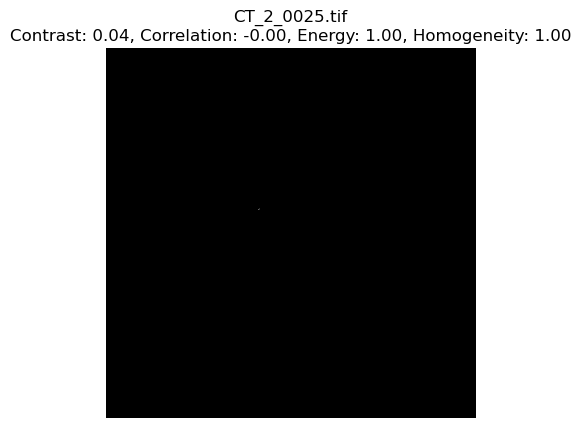

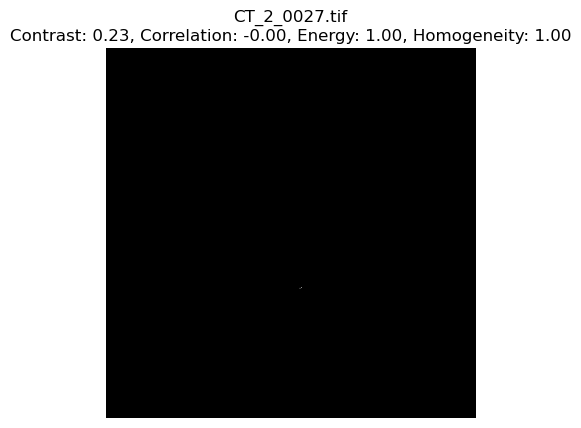

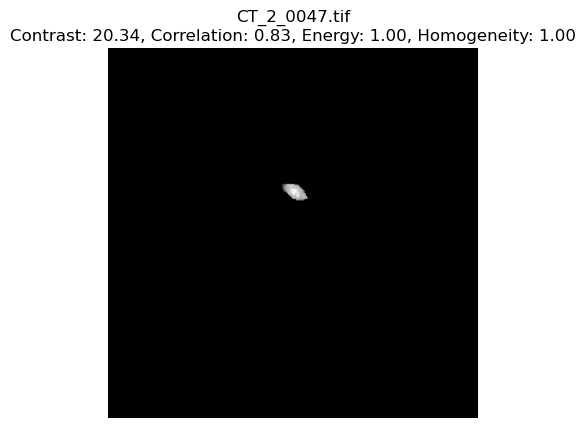

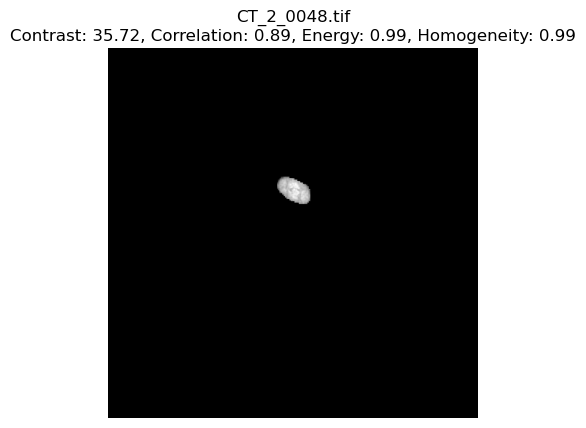

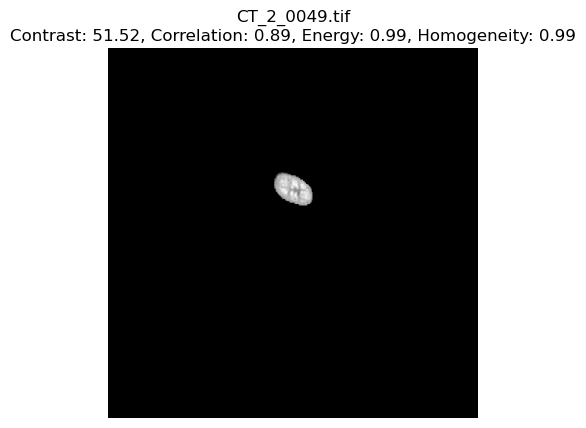

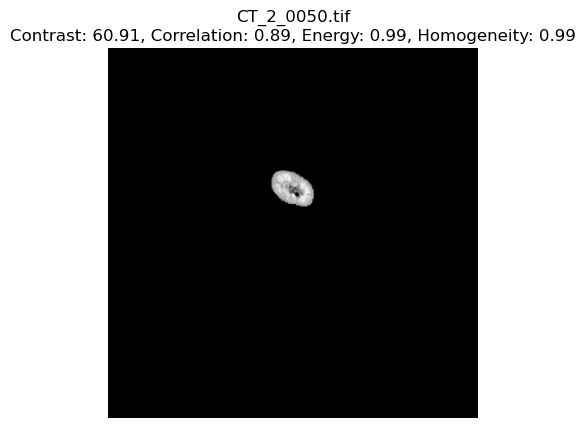

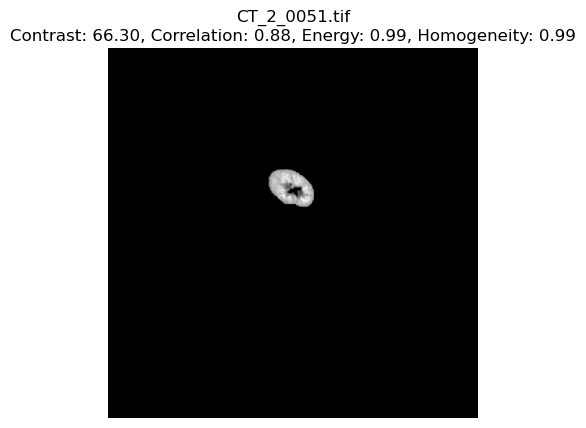

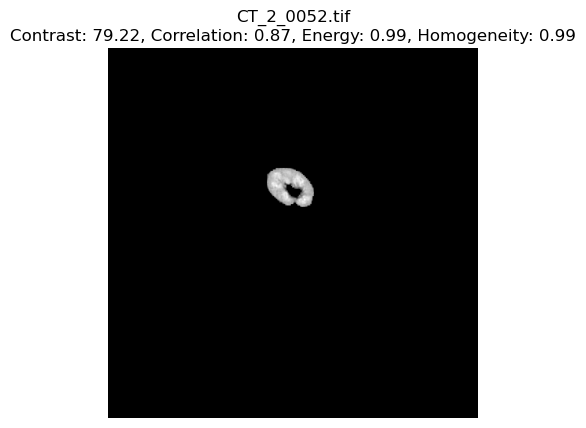

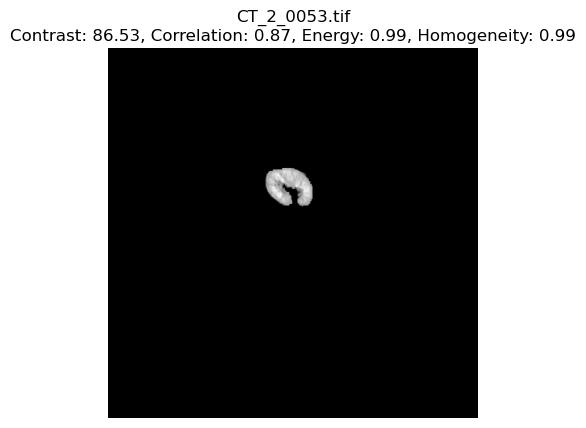

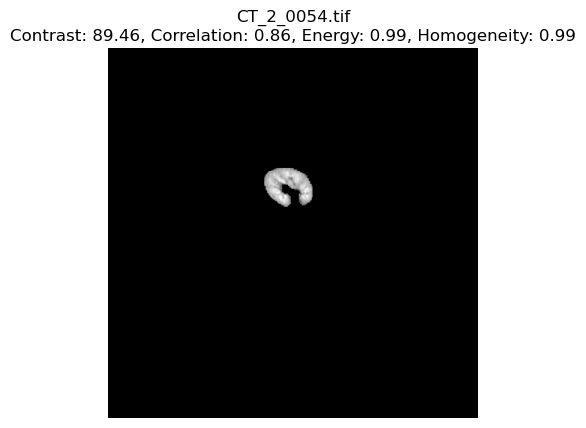

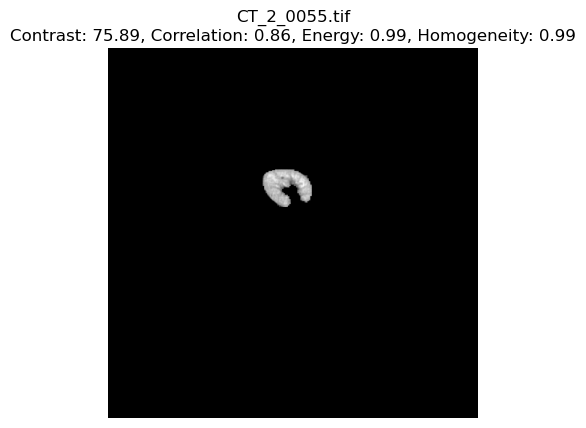

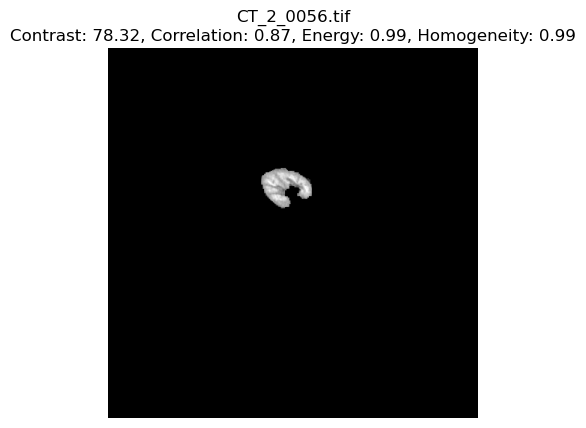

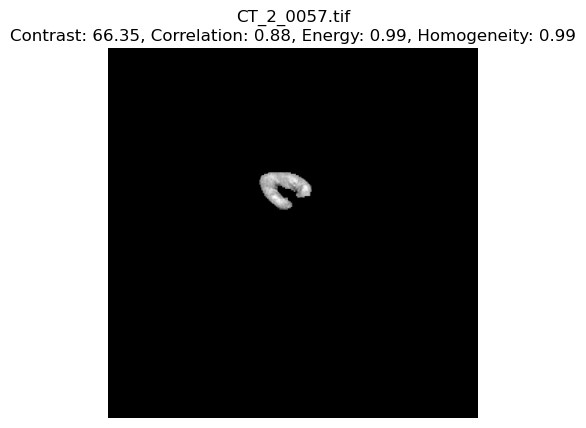

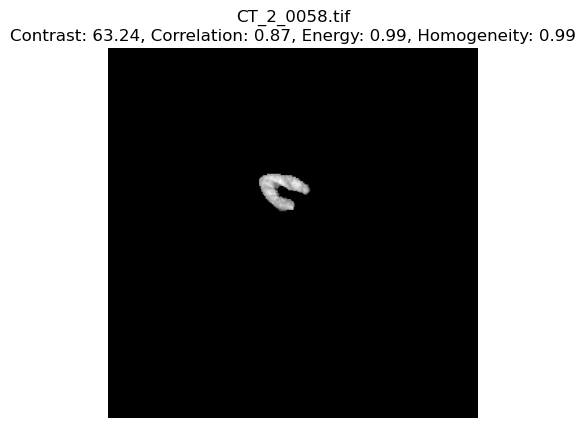

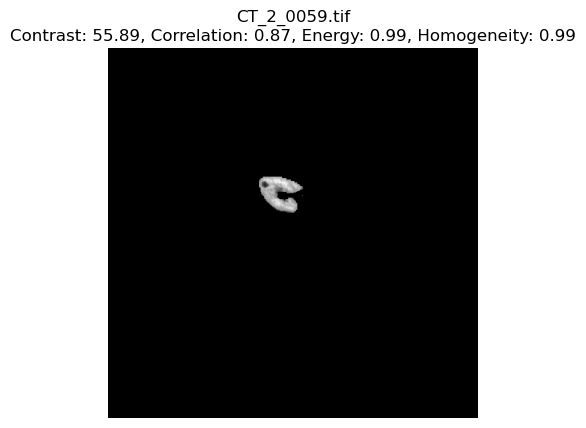

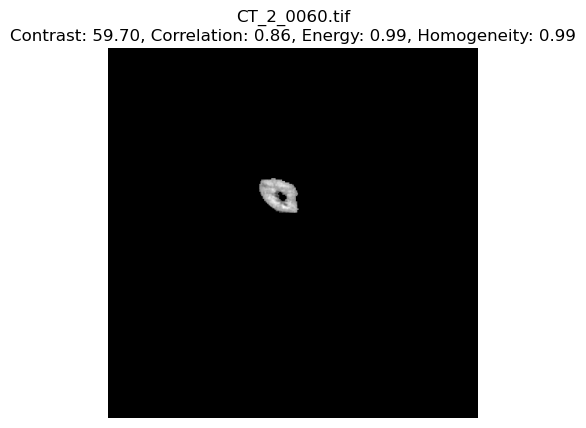

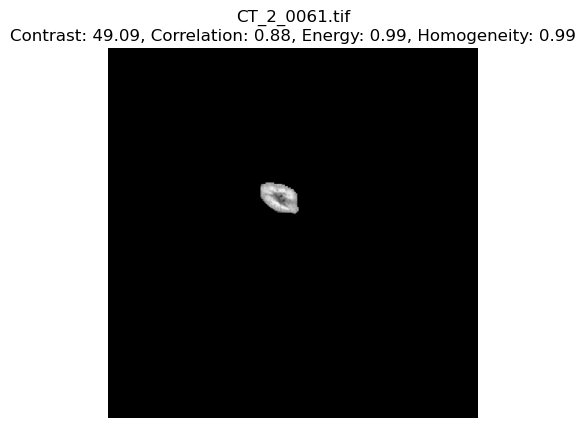

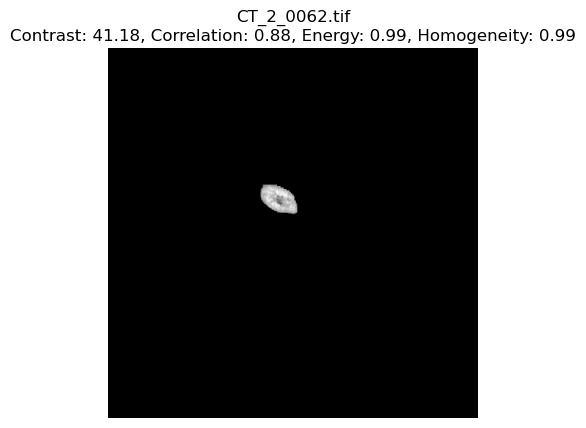

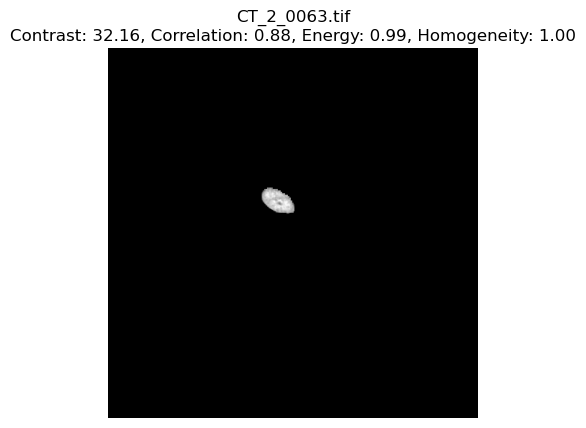

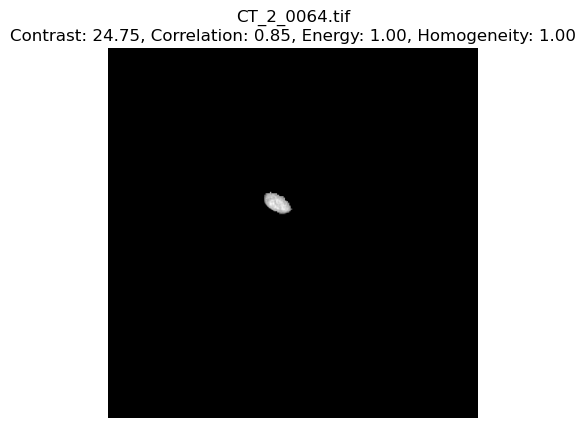

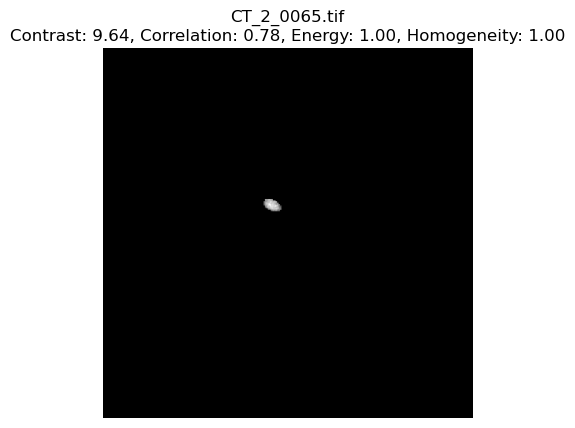

In [11]:
image_directory = "/Users/colehanan/Desktop/Important_AMOS/slicedUpImage500/group_4/CT_2"

# For this example (CT), we automatically create a converted folder inside the image directory.
# The folder name will be the image directory plus a subfolder (here "CT_2_converted").
converted_directory = os.path.join(image_directory, "(CT_2_converted")
if not os.path.exists(converted_directory):
    os.makedirs(converted_directory)

# The CSV output file will be placed in the converted folder.
output_csv = os.path.join(converted_directory, "texture_analysis_results.csv")

# Set the modality. Use "CT" for CT images or "MRI" for MRI images.
modality = "CT"  # Change to "MRI" if needed

# Run the analysis.
if modality.upper() == "CT":
    all_features = analyze_image_stack(image_directory, modality, output_csv, converted_directory)
    show_ct_images_with_analysis(converted_directory, all_features)
elif modality.upper() == "MRI":
    all_features = analyze_image_stack(image_directory, modality, output_csv)
    show_mri_images_with_analysis(image_directory, all_features)
else:
    print("Unsupported modality. Use 'CT' or 'MRI'.")